In [1]:
%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from pygam import f
seaborn.set(style='ticks')
from pygam import LinearGAM, s
import holidays

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['figure.figsize'] = (35.0, 15.0)

In [3]:
# read into load data
df = pd.read_pickle('raw_elec.pkl')
df['hour'] = df.index.hour
df['date'] = df.index.date
df['weekday'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

df = df.loc['2013-1':'2017-7',]
df['data'] = df['data'].astype('float64')
se_holidays = []
for year in list(range(2013,2018)):
    for ptr in holidays.SE(years = year).items(): 
        if ptr[1] !='Söndag':
            se_holidays.append(ptr[0].strftime('%Y-%m-%d'))
df['se-holiday'] = [ i.strftime('%Y-%m-%d') in se_holidays for i in df.index]
df['se-holiday'] = df['se-holiday'].astype(int)
df.loc[df['month'].isin([6,7]),'se-holiday']=2

df.columns = ['y','x_tod','x_date','x_dow','x_mon','x_year','x_holiday']
df['weekhour'] = (df['x_tod']+24*(df['x_dow']))

In [4]:
# read into weather data
weather_df = pd.read_csv("SMHI/smhi_bromma_2013_to_2018_05.csv",
                         delimiter=";",index_col='timestamp')
df_temp = df.join(weather_df[['temp_degC','irradwpm²']]).dropna()

In [5]:
for i in list(range(1,25)):
    df_temp['y-'+str(i)] = df_temp[['y']].shift(i)
# remove the 0 value
df_temp.loc[df_temp['y']==0,'y'].replace(0,np.nan)
df_temp.loc[df_temp['y']==0,'y'] = np.nan
df_temp[['y']] = df_temp[['y']].interpolate(method='linear')

df_temp = df_temp.dropna()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    216.7131
Link Function:                     IdentityLink Log Likelihood:                               -188085.8189
Number of Samples:                        34928 AIC:                                            376607.064
                                                AICc:                                          376609.8077
                                                GCV:                                               87.4879
                                                Scale:                                             86.5114
                                                Pseudo R-Squared:                                   0.8601
Feature Function                  Lam

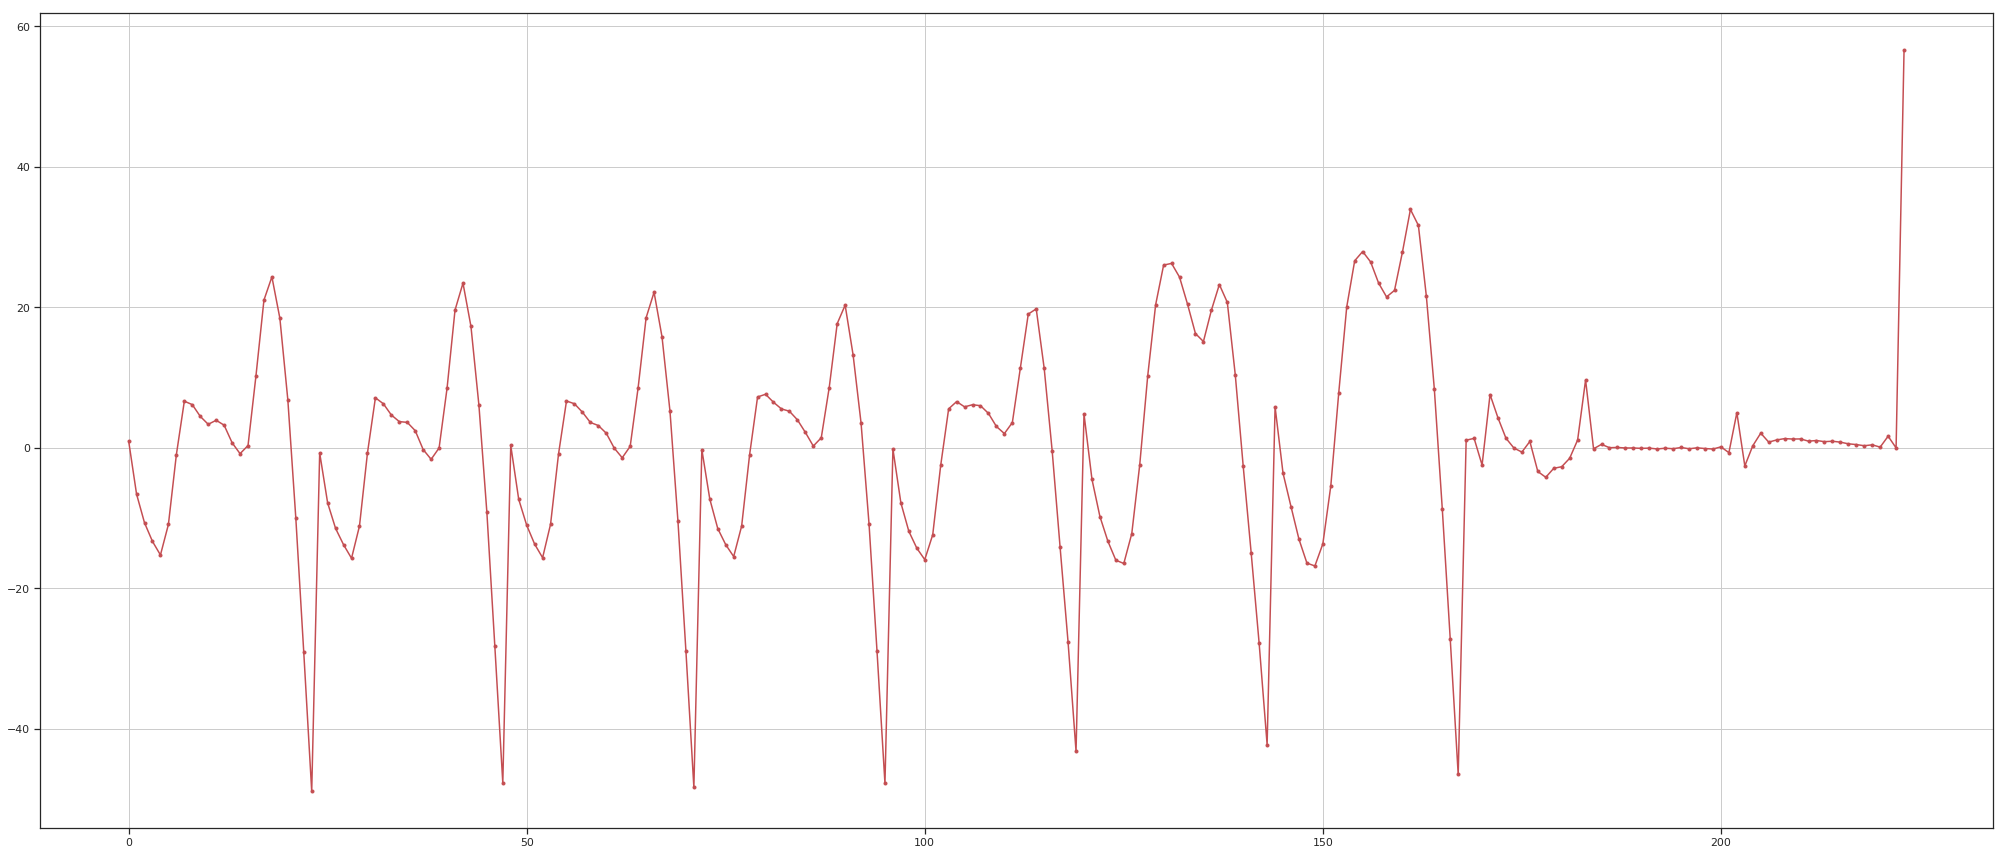

In [6]:
feature_list = ['weekhour', # 7days X 24hours
                'x_holiday',
                'x_dow',
                'x_tod',
                'irradwpm²',
                'temp_degC',
                'x_mon'
               ]

X, y = df_temp.loc['2013':'2016',feature_list], df_temp.loc['2013':'2016',['y']]

gam = LinearGAM(
                f(0) #0.6819
                + f(1) # 0.7302
                + f(6)
                + s(4,by=3) 
                + s(5,by=3) 
               ).fit(X, y) 
print(gam.summary())


plt.plot(gam.coef_,'r.-')
plt.grid(True)

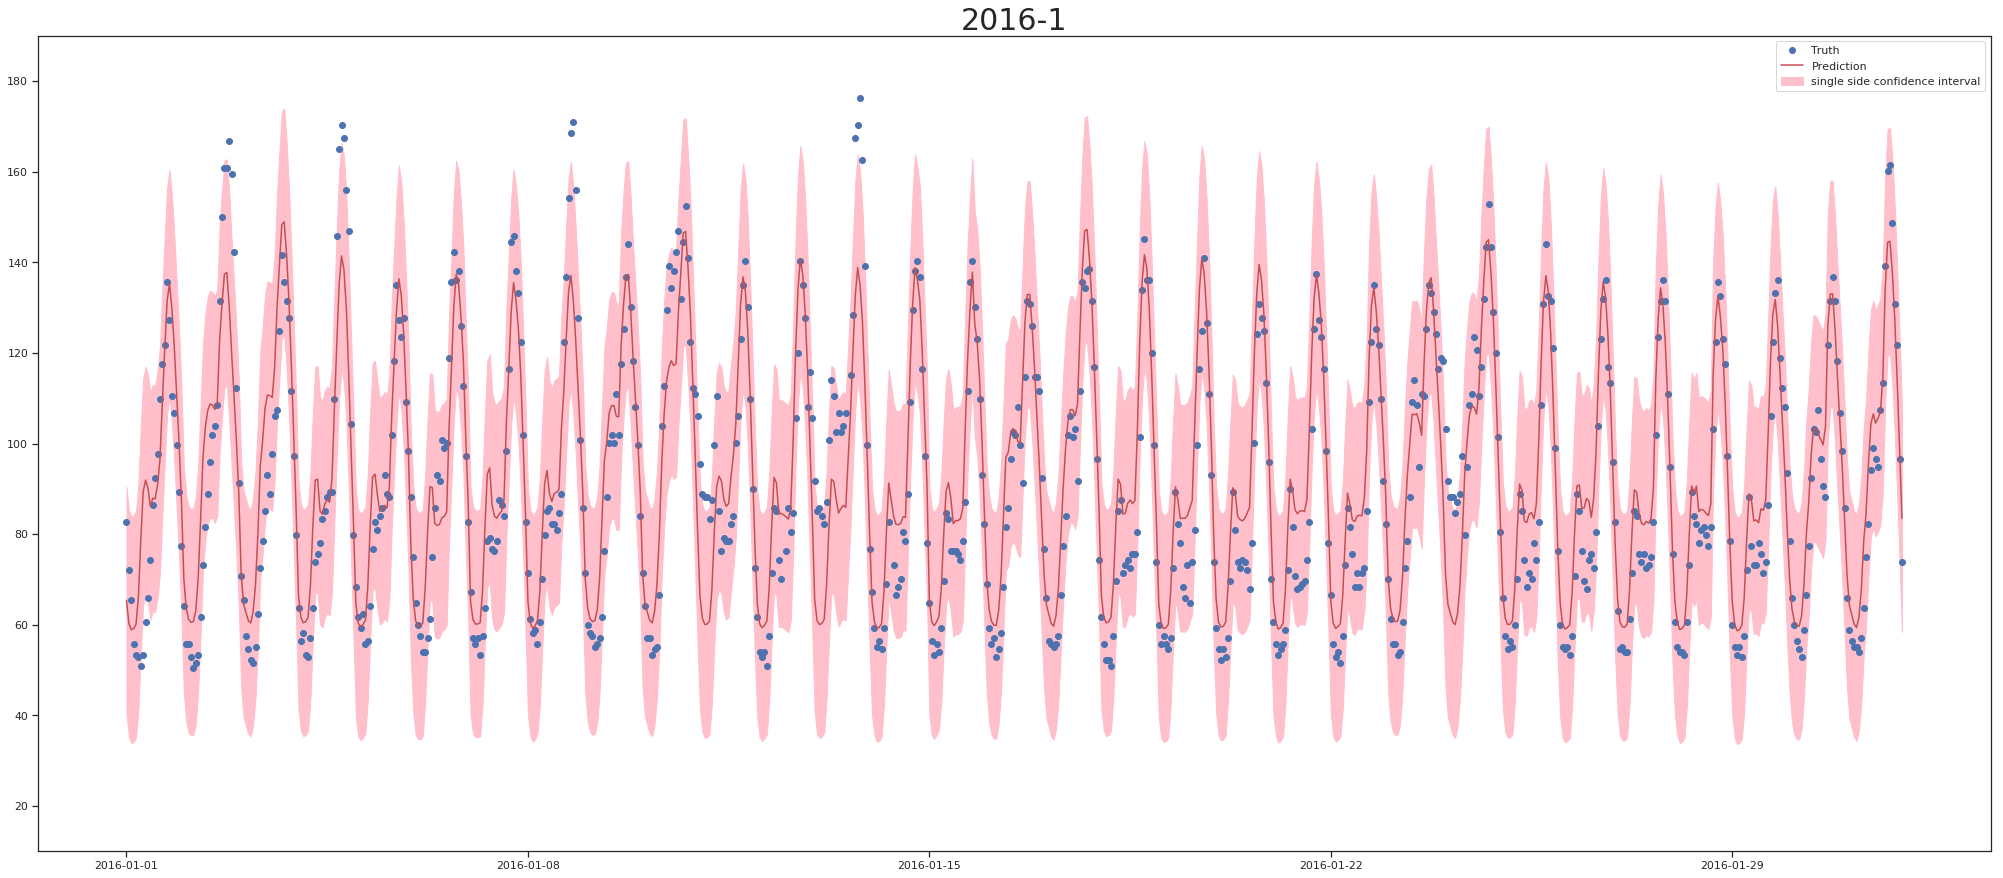

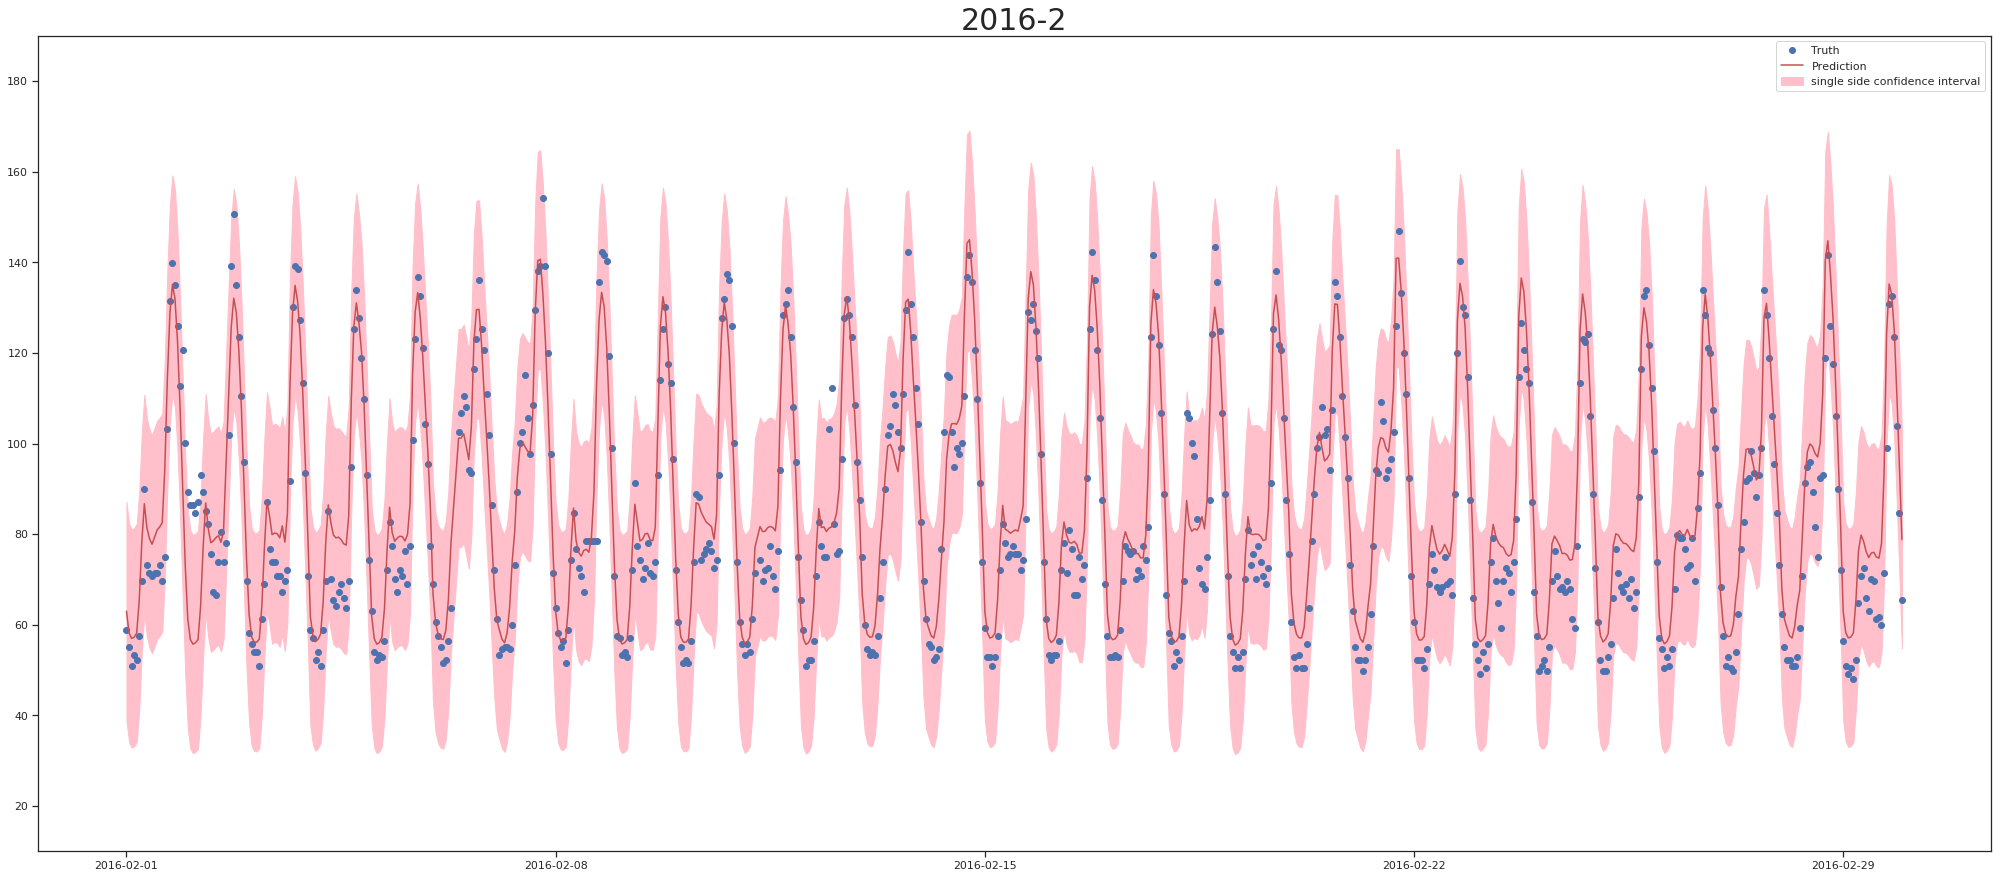

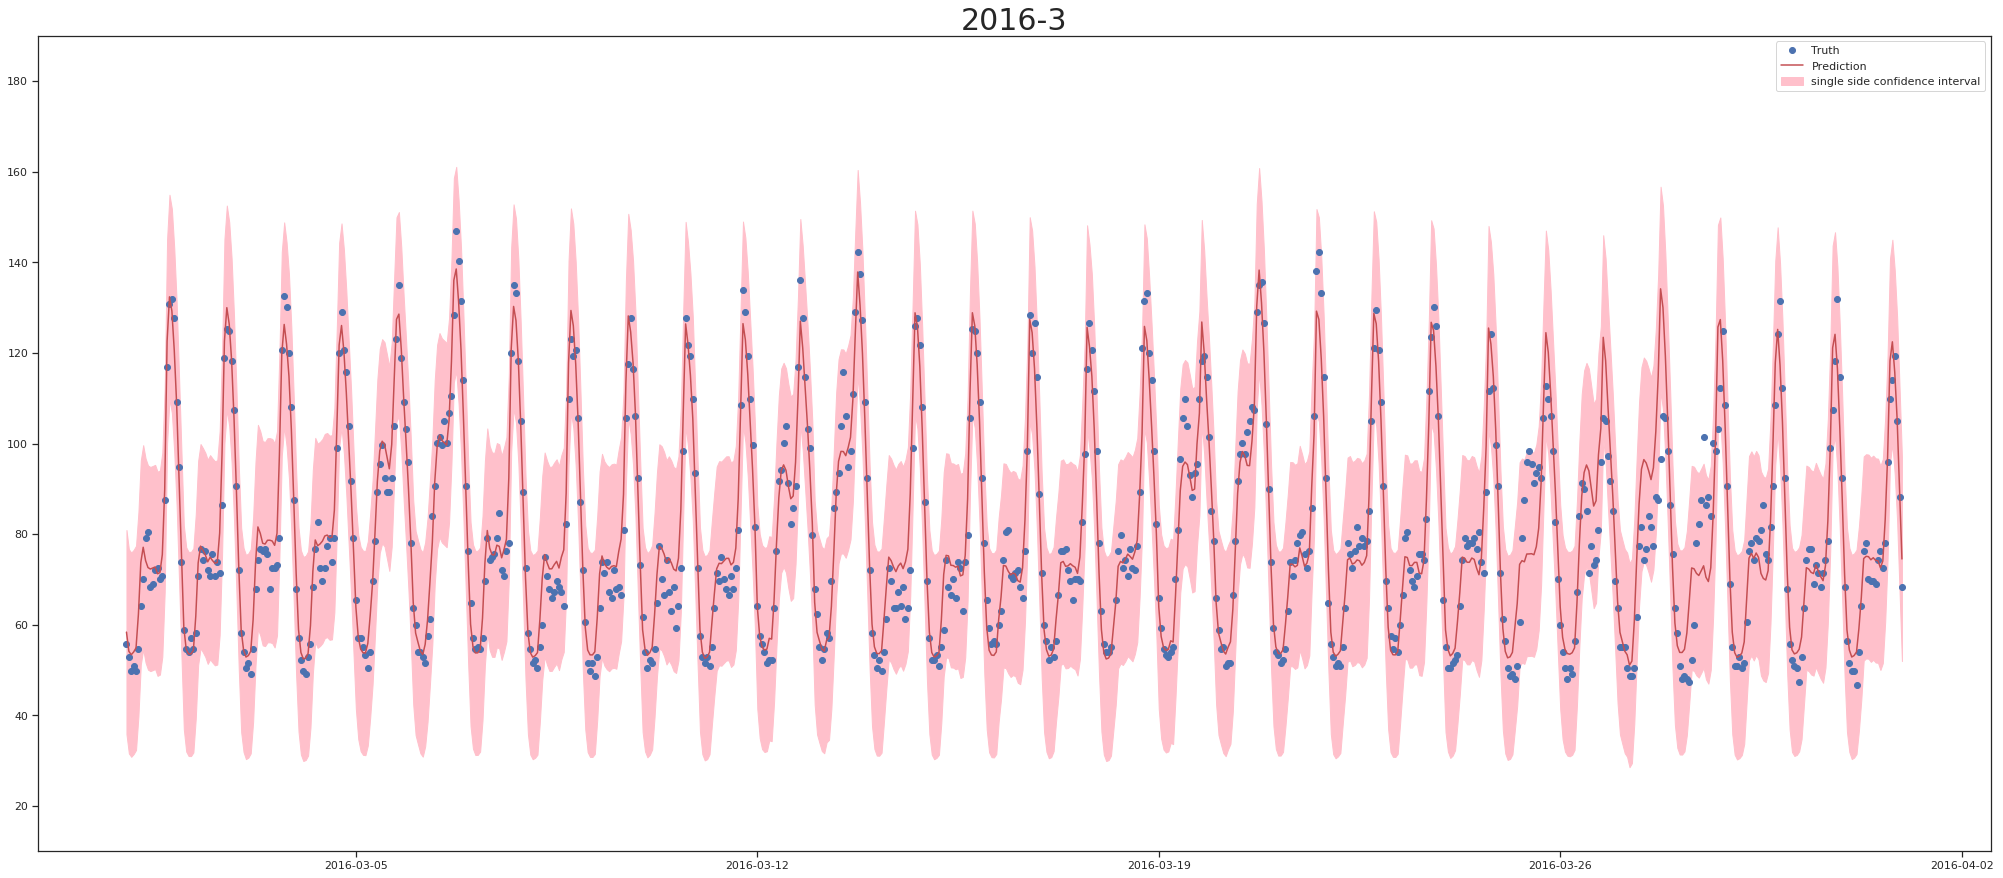

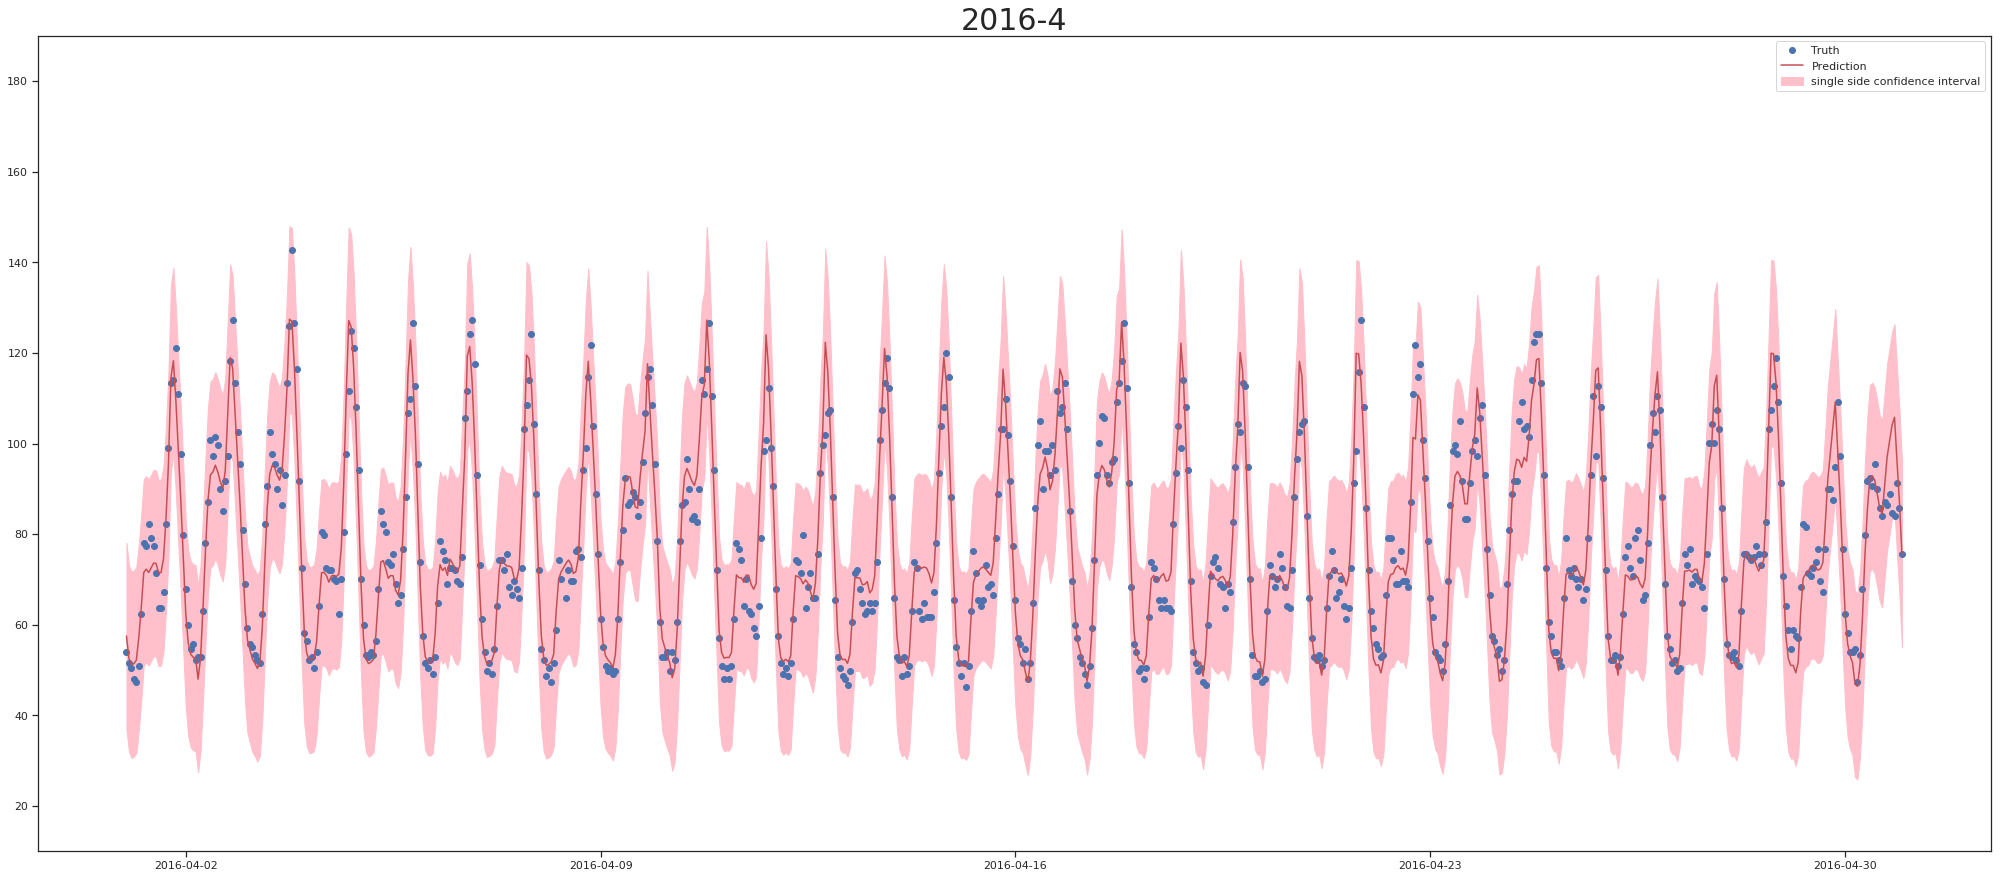

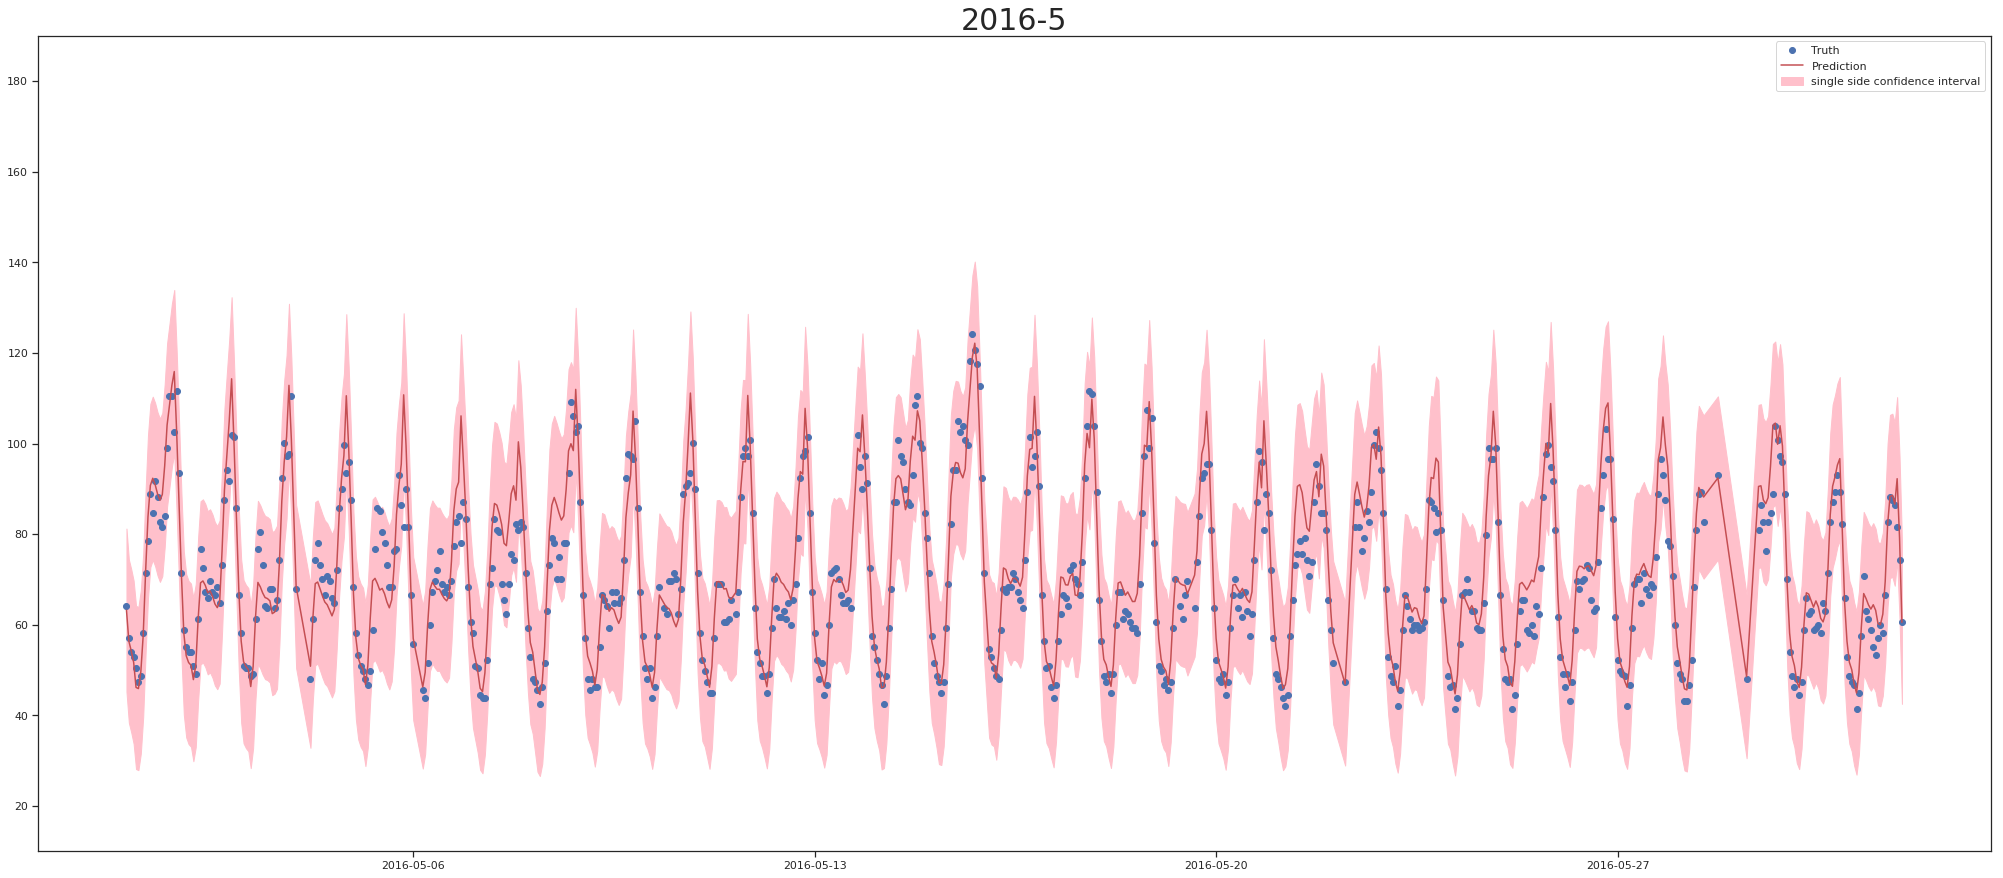

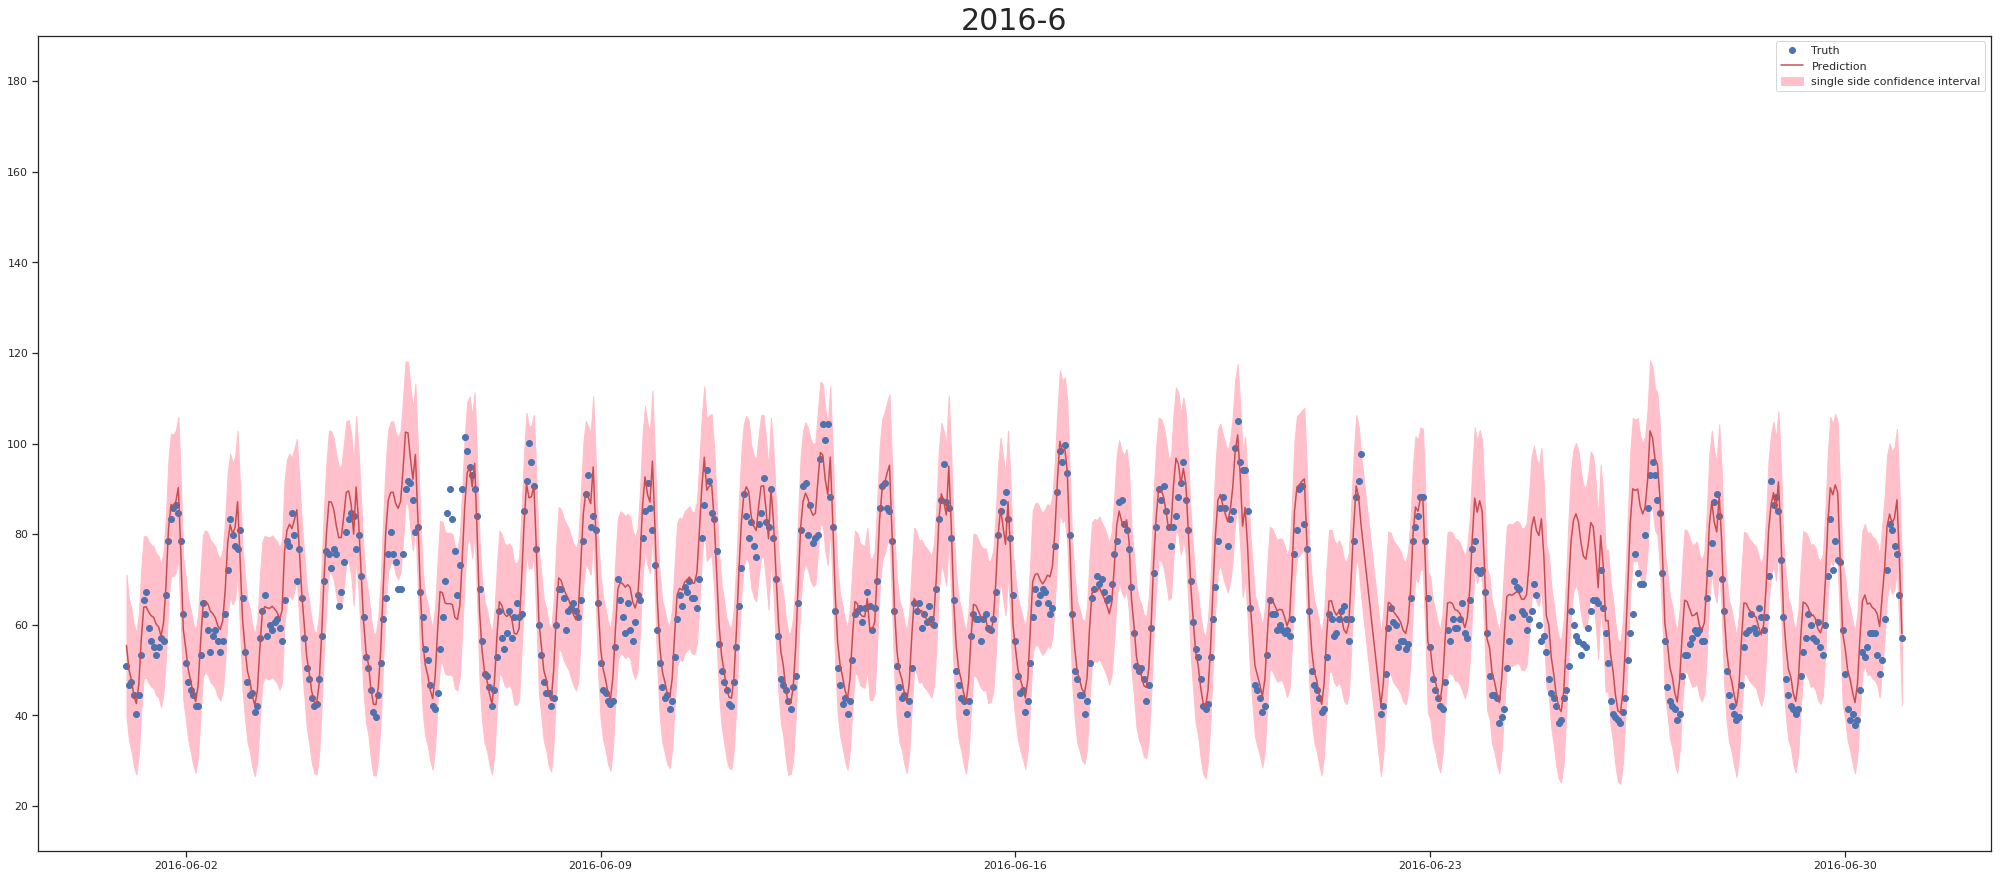

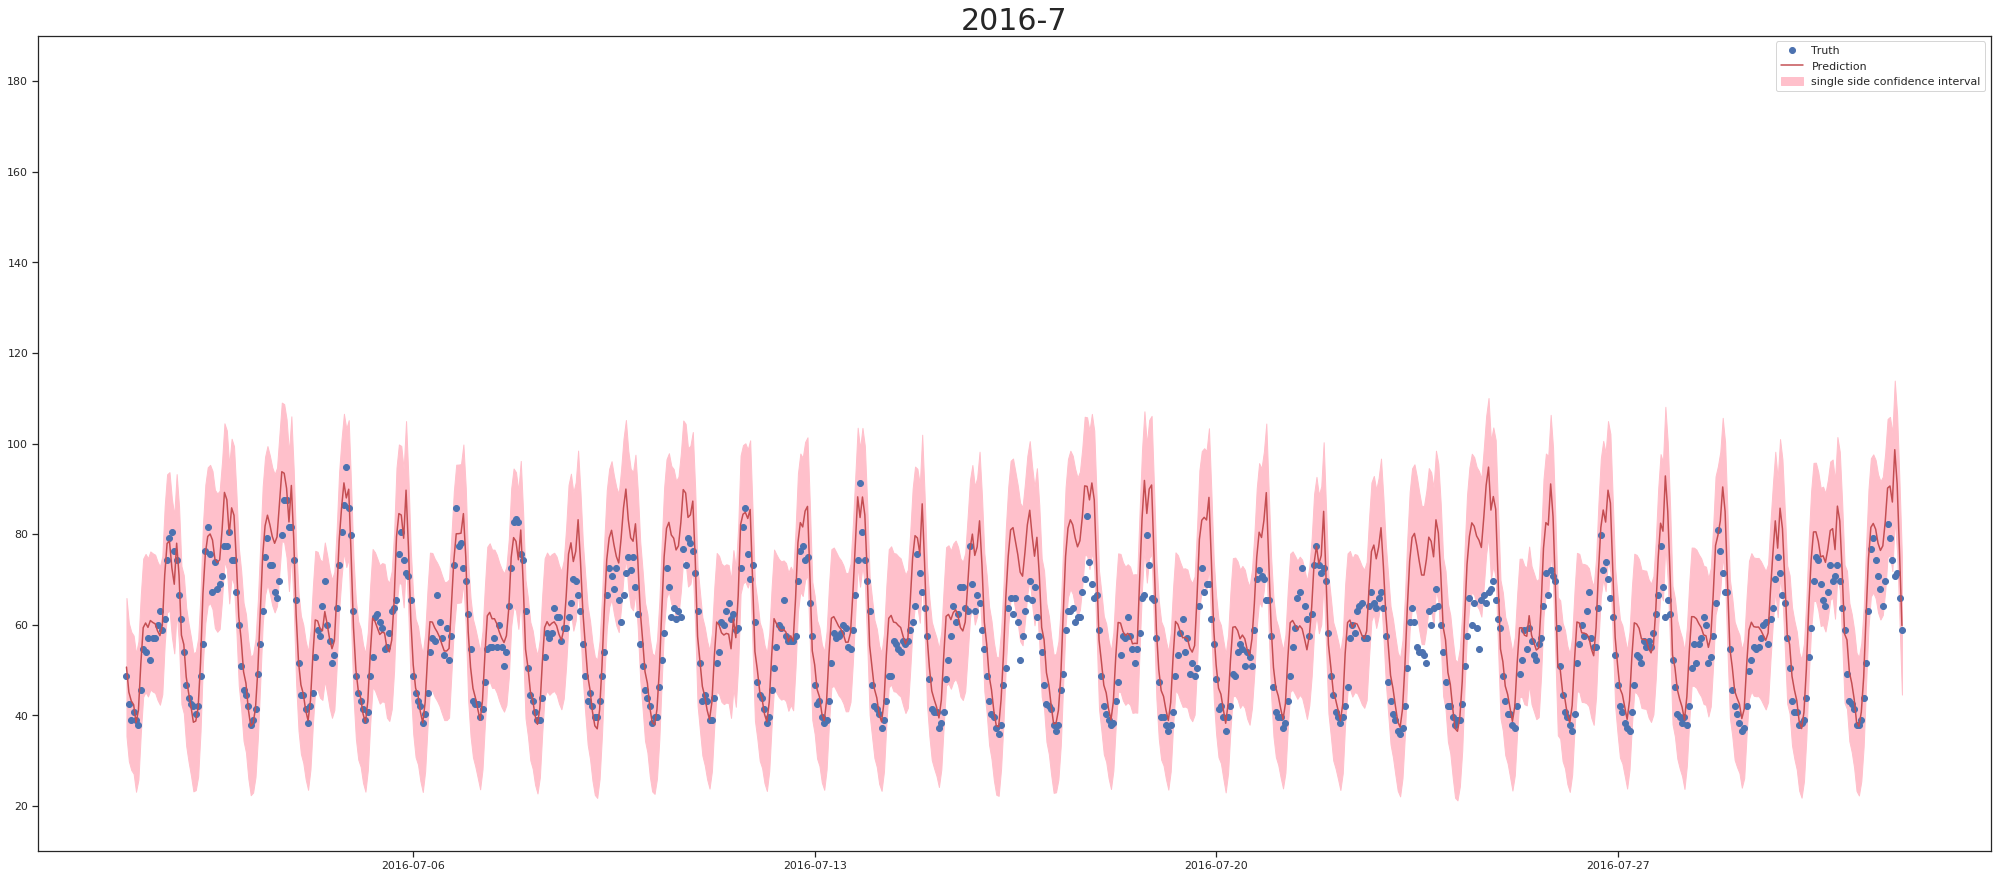

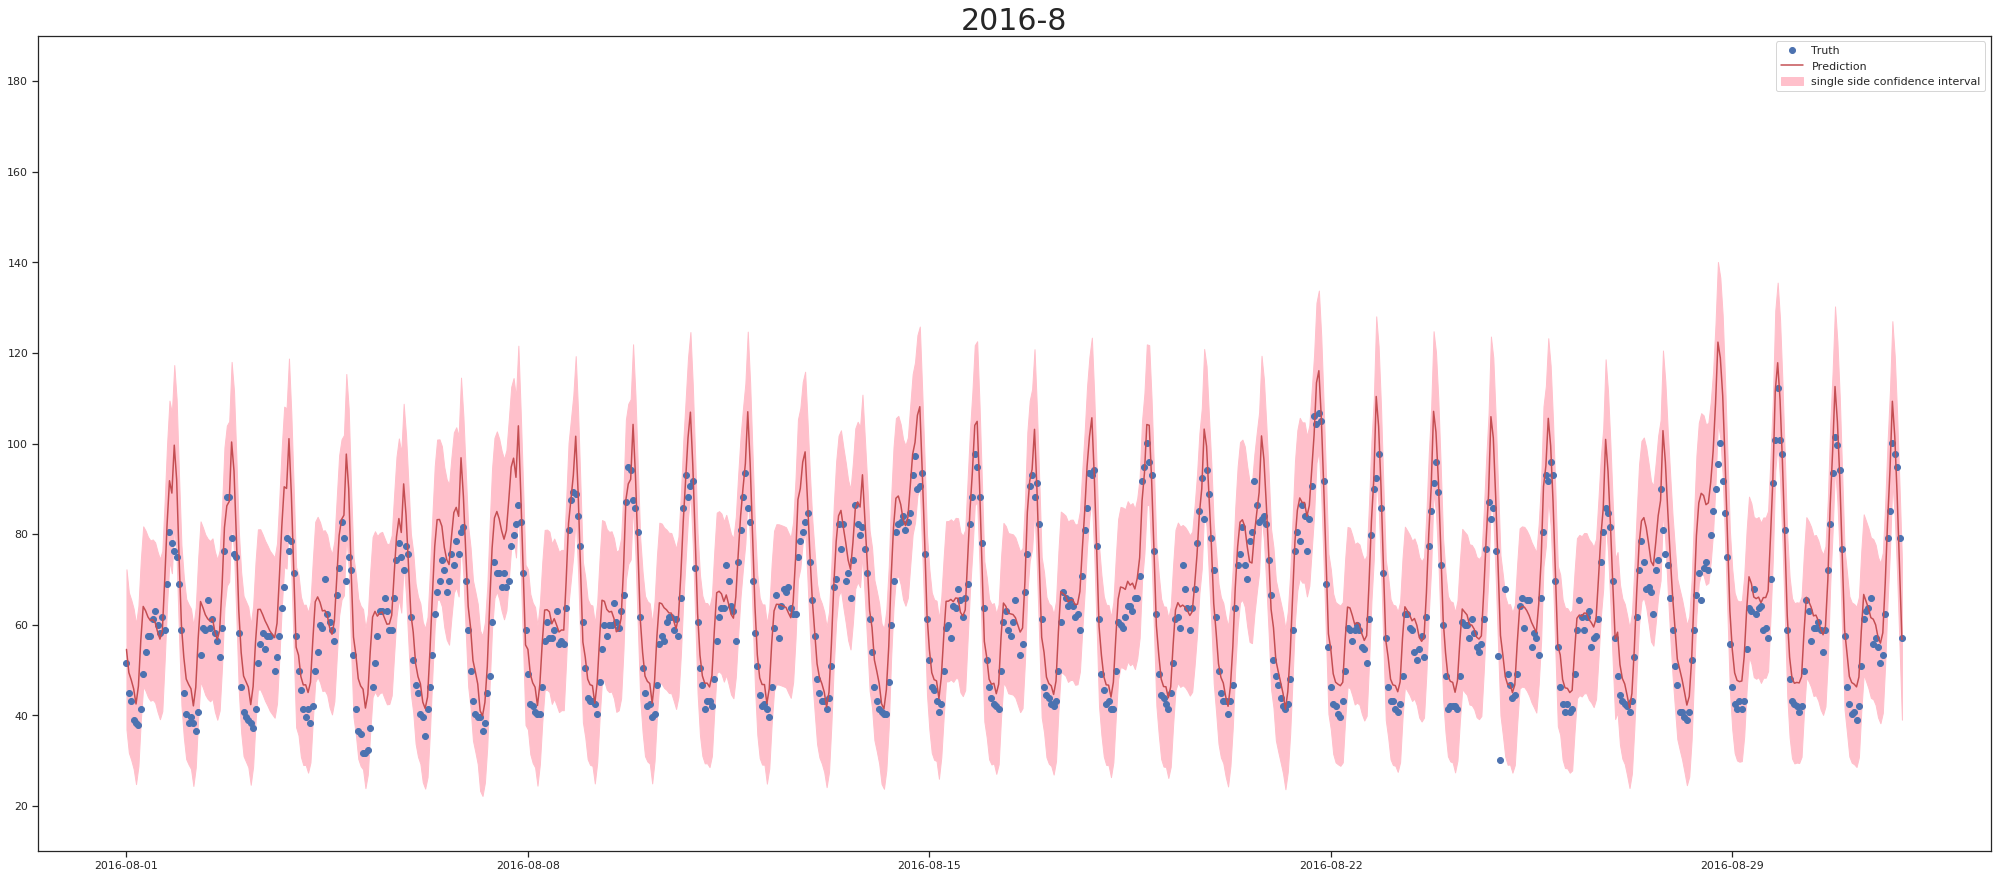

In [ ]:
test_year = 2016
Result = df_temp.loc[str(test_year),feature_list+['y']]
Result['p'] = gam.predict(df_temp.loc[str(test_year),feature_list])


time_list = []
for year in list(range(test_year,test_year+1)):
    for month in list(range(1,13)):
        time_list.append(str(year)+'-'+str(month))
for i in time_list: 
    fig, ax = plt.subplots()
    plt.title(i,fontsize=30)
    plt.ylim(10,190)

    Result_month = Result.loc[i,]
    dy_yfit = Result.loc[i,'p'].describe().loc['std',]
    
#     print(mean,Result_month[Result_month['y']>mean]['p']+  dy_yfit)
    ax.plot(Result_month.index, Result_month[['y']], 'ob',label="Truth")
    ax.plot(Result_month.index, Result_month[['p']], '-', color='r',label="Prediction")
    ax.fill_between(Result_month.index, 
                    Result_month['p'].values- dy_yfit,  
                    Result_month['p'].values+ dy_yfit,
                    color='pink', alpha=1,label='single side confidence interval')
    ax.legend(loc="best")

In [ ]:
# based on the first model,add "one hour ago" and "24hours ago" history load 

feature_list = ['weekhour',
                'x_holiday',
                'x_dow',
                'x_tod',
                'irradwpm²',
                'temp_degC',
                'x_mon',
                'y-24',
                'y-1'
               ]

X, y = df_temp.loc['2013':'2016',feature_list], df_temp.loc['2013':'2016',['y']]

gam = LinearGAM(
                f(0) #0.6819
#                 + f(1) # 0.7302
                + f(6)
                + s(4,by=3) 
                + s(5,by=3) 
                + s(7)  # 0.9046
                + s(8)
                
               ).fit(X, y) 
print(gam.summary())

plt.title('all coefficients',fontsize=30)
plt.plot(gam.coef_,'r.-')
plt.grid(True)

In [ ]:
test_year = 2014
Result = df_temp.loc[str(test_year),feature_list+['y']]
Result['p'] = gam.predict(df_temp.loc[str(test_year),feature_list])

print(Result.info())

time_list = []
for year in list(range(test_year,test_year+1)):
    for month in list(range(1,13)):
        time_list.append(str(year)+'-'+str(month))
for i in time_list: 
    fig, ax = plt.subplots()
    plt.title(i,fontsize=30)
    plt.ylim(10,190)

    Result_month = Result.loc[i,]
    dy_yfit = Result.loc[i,'y-24'].describe().loc['std',]
    
#     print(mean,Result_month[Result_month['y']>mean]['p']+  dy_yfit)
    ax.plot(Result_month.index, Result_month[['y']], 'ob',label="Truth")
    ax.plot(Result_month.index, Result_month[['p']], '-', color='r',label="Prediction")
    ax.fill_between(Result_month.index, 
                    Result_month['p'].values- 0,#dy_yfit,  
                    Result_month['p'].values+ dy_yfit,
                    color='pink', alpha=1,label='confidence interval')
    ax.legend(loc="best")